In [173]:
!pip install deap

from deap import base
from deap import creator
from deap import tools

import random

import matplotlib.pyplot as plt


In [174]:
# Genetic Algorithm constants:
POPULATION_SIZE = 500
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.1   # probability for mutating an individual
MAX_GENERATIONS = 326

#Set any problem-specific constants here. In this case we need to know how long the string is.
ONE_MAX_LENGTH = 100  # length of bit string to be optimized


The following code creates 100 items with values ranging from 1 to 10 and weights ranging from 1 to 100. Make sure you include this with no changes so that you have the correctly specified problem.


In [175]:
NBR_ITEMS = 100
MAX_WEIGHT = 1000

# set the random seed. Make sure you do this BEFORE creating the knapsack
# creating the knapsack
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# Create the item dictionary: item name is an integer, and value is
# a (value, weight) 2-uple.

items = {}

# Create random items and store them in the items' dictionary.
for i in range(NBR_ITEMS):
     items[i] = (random.randint(1, 10), random.randint(1, 100))

Create our toolbox. Note that we can pull in a bunch of predefined operators to tailor our Evolutionary Algorithm, which, of course, in this case is a GA. Notice that it is possible to create our own operators and functions to use, which is what we do with our oneMaxFitness function below.

In [176]:
def knapsack_fitness(individual):
    """knapsack_fitness, It provides total value for an individual"""
    total_value = 0
    total_weight = 0

    for index in range(len(individual)):
        if individual[index] == 1:
            total_value = total_value + items[index][0]   # Calculating Total Value
            total_weight = total_weight + items[index][1] # Calculating Total Weight

    if total_weight > MAX_WEIGHT:
        # Apply a penalty for exceeding the weight limit
        return (total_value - (total_weight - MAX_WEIGHT),)
    else:
        return (total_value,)


In [177]:
toolbox = base.Toolbox()

# create an operator that randomly returns 0 or 1:
toolbox.register("zeroOrOne", random.randint, 0, 1)

# define a single objective, maximizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# create the Individual class based on list:
creator.create("Individual", list, fitness=creator.FitnessMax)
#creator.create("Individual", array.array, typecode='b', fitness=creator.FitnessMax)

# create the individual operator to fill up an Individual instance:
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.zeroOrOne, ONE_MAX_LENGTH)

# create the population operator to generate a list of individuals:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)


# fitness calculation:
# compute the number of '1's in the individual
def oneMaxFitness(individual):
    return sum(individual),  # return a tuple


toolbox.register("evaluate", knapsack_fitness)

# genetic operators:

# Tournament selection with tournament size of 3:
toolbox.register("select", tools.selTournament, tournsize=2)


# Single-point crossover:
toolbox.register("mate", tools.cxOnePoint)

# Flip-bit mutation:
# indpb: Independent probability for each attribute to be flipped
toolbox.register("mutate", tools.mutFlipBit, indpb=1.0/ONE_MAX_LENGTH)


/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Here is the main GA loop. We will iterate through it up to the MAX_GENERATIONS parameter and then print out our best individual.

In [178]:
# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)
generationCounter = 0

# calculate fitness tuple for each individual in the population:
fitnessValues = list(map(toolbox.evaluate, population))
for individual, fitnessValue in zip(population, fitnessValues):
    individual.fitness.values = fitnessValue

# extract fitness values from all individuals in population:
fitnessValues = [individual.fitness.values[0] for individual in population]

# initialize statistics accumulators:
maxFitnessValues = []
meanFitnessValues = []
max_Fit= 0


# main evolutionary loop:
# stop if max fitness value reached the known max weight
# OR if number of generations exceeded the preset value:
while max(fitnessValues) < MAX_WEIGHT and generationCounter < MAX_GENERATIONS:
    # update counter:

    generationCounter = generationCounter + 1

    # apply the selection operator, to select the next generation's individuals:
    offspring = toolbox.select(population, len(population))
    # clone the selected individuals:
    offspring = list(map(toolbox.clone, offspring))

    # apply the crossover operator to pairs of offspring:
    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < P_CROSSOVER:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < P_MUTATION:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # calculate fitness for the individuals with no previous calculated fitness value:
    freshIndividuals = [ind for ind in offspring if not ind.fitness.valid]
    freshFitnessValues = list(map(toolbox.evaluate, freshIndividuals))
    for individual, fitnessValue in zip(freshIndividuals, freshFitnessValues):
        individual.fitness.values = fitnessValue

    # replace the current population with the offspring:
    population[:] = offspring

    # collect fitnessValues into a list, update statistics and print:
    fitnessValues = [ind.fitness.values[0] for ind in population]

    maxFitness = max(fitnessValues)
    meanFitness = sum(fitnessValues) / len(population)
    maxFitnessValues.append(maxFitness)
    meanFitnessValues.append(meanFitness)
    print("- Generation {}: Max Fitness = {}, Avg Fitness = {}".format(generationCounter, maxFitness, meanFitness))
    if maxFitness > max_Fit:
      max_Fit = maxFitness

    if max_Fit >=280:
      break
    # find and print best individual:
    #best_index = fitnessValues.index(max(fitnessValues))
    #print("Best Individual = ", *population[best_index], "\n")

 # Find and print the best individual

best_index = fitnessValues.index(max(fitnessValues))
best_individual = population[best_index]
total_weight = sum(items[i][1] for i in range(NBR_ITEMS) if best_individual[i] == 1)

print("Best Individual:", best_individual)
print("Best Fitness:", max(fitnessValues))
print("Total Weight for Best Individual:", total_weight)

print(f"MaxFitness reached is {max_Fit}")

- Generation 1: Max Fitness = -377.0, Avg Fitness = -1213.26
- Generation 2: Max Fitness = -328.0, Avg Fitness = -1070.066
- Generation 3: Max Fitness = -275.0, Avg Fitness = -939.432
- Generation 4: Max Fitness = -7.0, Avg Fitness = -796.514
- Generation 5: Max Fitness = -151.0, Avg Fitness = -694.44
- Generation 6: Max Fitness = -22.0, Avg Fitness = -592.398
- Generation 7: Max Fitness = 2.0, Avg Fitness = -498.08
- Generation 8: Max Fitness = 95.0, Avg Fitness = -396.696
- Generation 9: Max Fitness = 97.0, Avg Fitness = -305.522
- Generation 10: Max Fitness = 167.0, Avg Fitness = -221.148
- Generation 11: Max Fitness = 149.0, Avg Fitness = -144.49
- Generation 12: Max Fitness = 186.0, Avg Fitness = -67.666
- Generation 13: Max Fitness = 183.0, Avg Fitness = 0.636
- Generation 14: Max Fitness = 181.0, Avg Fitness = 59.52
- Generation 15: Max Fitness = 187.0, Avg Fitness = 96.272
- Generation 16: Max Fitness = 192.0, Avg Fitness = 117.502
- Generation 17: Max Fitness = 193.0, Avg Fitn

Now that we're done, let's print out some statistics. Generally we record (at least) the max and average over time.

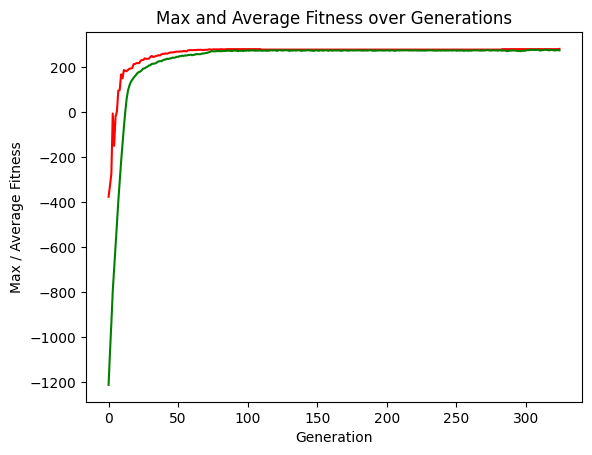

Population Size(500) and Max Generation (326)


In [179]:
# Genetic Algorithm is done - plot statistics:
#sns.set_style("whitegrid")
plt.plot(maxFitnessValues, color='red')
plt.plot(meanFitnessValues, color='green')
plt.xlabel('Generation')
plt.ylabel('Max / Average Fitness')
plt.title('Max and Average Fitness over Generations')
plt.show()


print(f"Population Size({POPULATION_SIZE}) and Max Generation ({MAX_GENERATIONS})")
#print(f"Individuals processed({POPULATION_SIZE*MAX_GENERATIONS}): the population size ({POPULATION_SIZE}) multiplied by the number of generations ({MAX_GENERATIONS}) required.")